# Week 4: Fourier transform: filtering and sampling

The exercise of this week is about Fourier Transform, image filtering and sampling. First load the following libraries that will be necessary.

In [1]:
!pip install scipy
!pip install scikit-image

In [50]:
%matplotlib inline

from time import time
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.ndimage import convolve
from scipy.fftpack import fft2, ifft2, fftshift
from scipy.signal import fftconvolve
from matplotlib.pyplot import imshow, show, figure
import numpy as np

Load the two images wall.jpg and sidewalk.jpg.

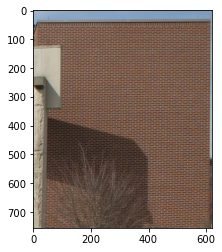

In [3]:
wall = np.array(imread('wall.jpg'), dtype=np.float) / 255.
wall_gray = rgb2gray(wall)
imshow(wall)

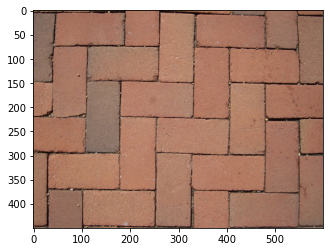

In [4]:
side = np.array(imread('sidewalk.jpg'), dtype=np.float) / 255.
side_gray = rgb2gray(side)
imshow(side)

Preliminary question: which of the two images has the most low pass content? Which one has the most high pass content?

Answer:

The following functions will be useful in the course of this tutorial: *fft2*, *ifft2*, *convolve* from scipy and the following function:

In [5]:
def gaussian_filter(shape, sigma):
    """
    Returns a 2D gaussian filter specified by its shape and standard deviation.
    """
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1, -n:n+1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

## Part A: Filtering

Create three Gaussian filters:
- one 5x5 Gaussian low pass filter with standard deviation 1
- one 15x15 Gaussian high pass filter with standard deviation 3.5. Hint: the high pass content of an image can be extracted by subtracting the low pass filtered image from the original image. Hence, you can get a high pass filter kernel from a low pass one by subtracting the low pass filter kernel from a unit impulse filter. A unit impulse filter is a filter full of 0s with a single 1 in the middle, that once convolved with an image returns the same image.
- one band pass filter. To do this, create first a 15x15 Gaussian filter with standard deviation 1 and then convolve this low pass filter with the previous high pass filter to create the band pass filter. Indeed, convolution is associative: img * band_pass = (img * low_pass) * high_pass = img * (low_pass * high_pass).

You can then visualize your filters in spatial and frequency domains (using *fft2* and *fftshift* from scipy for the latter). Since the filters are complex in the frequency domain, use *np.abs()* to display the magnitude of the filter.

In [24]:
# Low pass filter
low_pass_filter = gaussian_filter((5,5), 1)

# High pass filter
temp_lpf = gaussian_filter((15,15), 3.5)
unitimpulse = np.zeros_like(temp_lpf)
unitimpulse[7,7] = 1
high_pass_filter = unitimpulse - temp_lpf

# Band pass filter
bandfilter_lp = gaussian_filter((15,15), 1)
band_pass_filter = convolve(low_pass_filter, high_pass_filter)

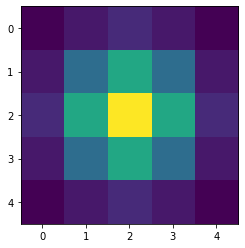

In [28]:
imshow(low_pass_filter)

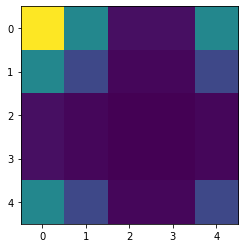

In [31]:
imshow(np.abs(fft2(low_pass_filter)))

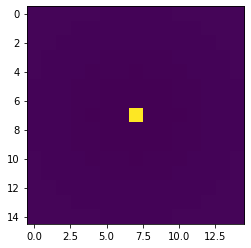

In [29]:
imshow(high_pass_filter)

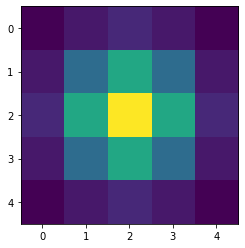

In [30]:
imshow(band_pass_filter)

Apply these three filters to the two sample grayscale images in spatial domain first by convolving the image with the kernel, and in frequency domain secondly by taking the Fourier tranform of both the image and the filter kernel and multiplying them. Compare the runtimes of spatial and frequency domain filtering, using the *time* function of python. Compare the filtering results of two images by visualizing the filtered images in both spatial and frequency domains. Check that your initial guess about the low/high pass content of the images is correct.

### Filtering in spatial domain

Original image:


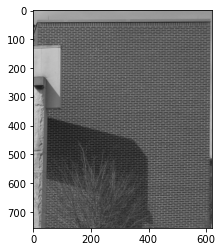

low pass


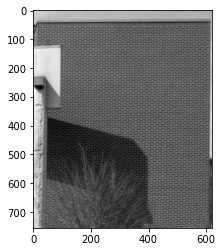

high pass


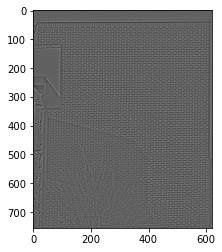

band pass


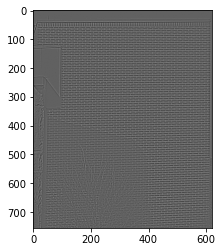

In [43]:
#%%timeit
print("Original image:")
imshow(wall_gray, cmap='gray')
show()
print("low pass")
imshow(convolve(wall_gray, low_pass_filter), cmap='gray')
show()
print("high pass")
imshow(convolve(wall_gray, high_pass_filter), cmap='gray')
show()
print("band pass")
imshow(convolve(wall_gray, band_pass_filter), cmap='gray')
show()
# 902 ms ± 24.3 ms

Original image:


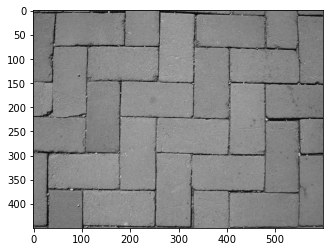

low pass


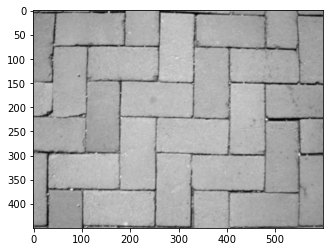

high pass


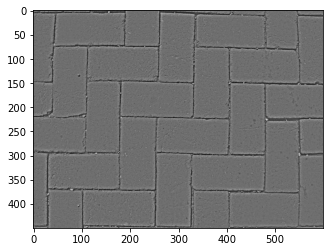

band pass


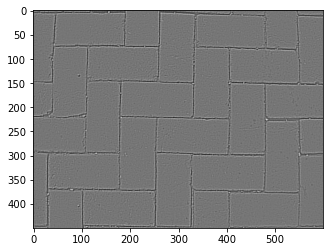

In [45]:
#%%timeit
print("Original image:")
imshow(side_gray, cmap='gray')
show()
print("low pass")
imshow(convolve(side_gray, low_pass_filter), cmap='gray')
show()
print("high pass")
imshow(convolve(side_gray, high_pass_filter), cmap='gray')
show()
print("band pass")
imshow(convolve(side_gray, band_pass_filter), cmap='gray')
show()
# 893 ms ± 19 ms

### Filtering in frequency domain

Note: the output of *ifft2* is a numpy array with complex values. You can use the command *.astype(float)* to convert it back to real numbers.

In [70]:
def fft2conv(im, filter):
    return ifft2(fft2(im) * fft2(filter, shape=im.shape)).astype(float)

Original image:


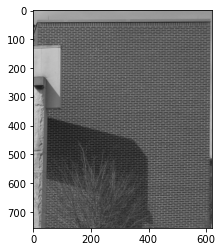

low pass image:


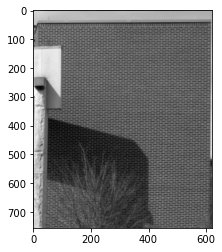

In [71]:
print("Original image:")
imshow(wall_gray, cmap='gray')
show()
print("low pass image:")
imshow(fft2conv(wall_gray, low_pass_filter).astype(float), cmap='gray')
show()

# Enter your code here

Original image:


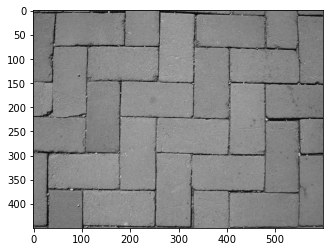

In [10]:
print("Original image:")
imshow(side_gray, cmap='gray')
show()

# Enter your code here

## Part B: Sampling

Downsample both images to one fourth of the resolution by taking every second row and column. You can use numpy array slicing for this: *my_array[start:end:step]*. Compare the results in terms of distortions and unexpected effects. Explain why the quality of the two downsampled images differ. 

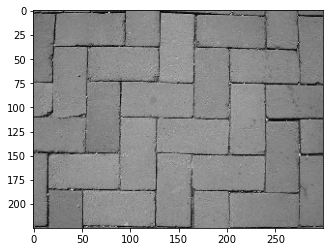

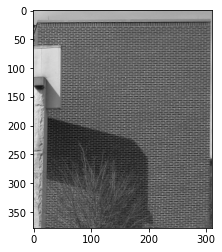

In [64]:
imshow(side_gray[::2,::2], cmap='gray')
show()
imshow(wall_gray[::2,::2], cmap='gray')

A high frequency loses more information with sampling that a lower frequency loses with the same rate

Create three 15x15 Gaussian low pass filters with standard deviations 0.5, 1 and 1.5 and apply them to the color image wall.jpg. You can filter the three channels separately and gather them in an RGB image with the numpy function *np.stack([r_img, g_img, b_img], axis=-1)*. Downsample the three filtered images to one fourth resolution. Compare the resulting downsampled images in terms of quality.

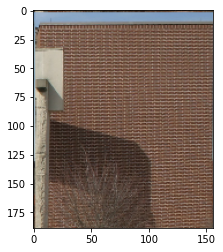

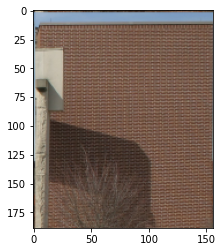

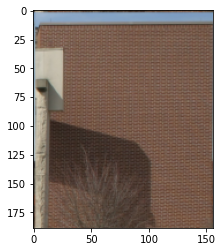

In [89]:
# Create the filters
lpf1 = gaussian_filter((15,15), 0.5)
lpf2 = gaussian_filter((15,15), 1)
lpf3 = gaussian_filter((15,15), 1.5)

# Convolve them with the RGB image
imchannels = []
for layer in [0,1,2]:
    imchannels.append(fft2conv(wall[:,:,layer], lpf1))
    imchannels.append(fft2conv(wall[:,:,layer], lpf2))
    imchannels.append(fft2conv(wall[:,:,layer], lpf3))

# Downsample the resulting images
scaledimages = [None]*3
for i in range(3):
    scaledimages[i] = np.stack(map(lambda x:x[::4,::4],imchannels[i::3]), axis=-1)
    imshow(scaledimages[i])
    show()

## Bonus: for those that finished earlier

Load the blurred road signs image and using your fresh knowledge about filters, design the perfect filter to make the text readable.

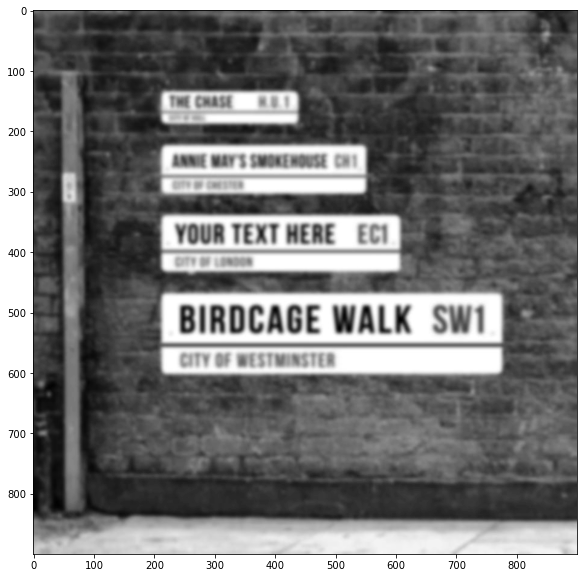

In [13]:
blurred_road_signs = np.array(imread('blurred_road_signs.jpg', as_gray=True), dtype=np.float) / 255.

figure(figsize=(10, 10))
imshow(blurred_road_signs, cmap='gray')
show()